In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Faster R-CNN in a custom dataset
In this document we will know how to work with a pre-trained Faster R-CNN model.


## 1. Install requires Libraries and import requires Modules.
First step is import all the neccesary modules. We need to install *Pytorch*, which is a framework (open source machine learning). Also we need to install *tourchvision* (part of Pytorch) a package consist of popular datasets, model architectures and common image transformations for computer vision.
In resume, *tourchvision* provides a Faster R-CNN model pre-trained on COCO dataset.

Pd: Generally, Google Colab already has the core libraries such as PyTorch and torchvision installed. So in this case we omit that step. In any case, we have to check the Pytorch and torchvision versions are compatibles.





In [ ]:
import torch
import torchvision
import os
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
import sys

print(sys.version)
print(torch.version.cuda)
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
12.4
PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


## 2. Prepare the Dataset
Then, we have to define a transfomation CocoTransform, because for Pytorch, we need to work with tensors.

In [ ]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
      ''' function, receives the image and target (class and bbox information)
           from dataset. This function converts the input into tensors, and
           returns image and target in tensors format.
      '''
      image = F.to_tensor(image)  # Convert PIL image to tensor
      return image, target

Now we need to prepare the dataset in COCO dataset format. And setup the data loader. We are using the directorys of train images and validation images, and them respective annotations files. **We don't need normalized coordinates** for this model, if this is the case, **the model won't work correctly**.

In [ ]:
# First we define the directorys for images and annotations file as variables.
t_img_dir = '/content/drive/MyDrive/Colab Notebooks/R-CNN/data/train/images'
t_ann_file= '/content/drive/MyDrive/Colab Notebooks/R-CNN/data/train/annotations/train_annotations.json'

v_img_dir = '/content/drive/MyDrive/Colab Notebooks/R-CNN/data/val/images'
v_ann_file= '/content/drive/MyDrive/Colab Notebooks/R-CNN/data/val/annotations/val_annotations.json'


# t_img_dir = '/content/drive/MyDrive/Colab Notebooks/R-CNN_full/data/train/images'
# t_ann_file= '/content/drive/MyDrive/Colab Notebooks/R-CNN_full/data/train/annotations/train_annotations.json'
# v_img_dir = '/content/drive/MyDrive/Colab Notebooks/R-CNN_full/data/val/images'
# v_ann_file= '/content/drive/MyDrive/Colab Notebooks/R-CNN_full/data/val/annotations/val_annotations.json'

# Dataset class
def get_coco_dataset(img_dir, ann_file):
    '''Function, receives the image directory and the name of anotation file.
       Prepares the datatset in COCO dataset format
    '''
    return CocoDetection(root=img_dir,
                         annFile=ann_file,
                         transforms=CocoTransform())

# Load train dataset in COCO format, this data are not normalized, but we'll do it
# in the training part, when we extract the bboxes.
train_dataset = get_coco_dataset(img_dir=t_img_dir,
                                 ann_file=t_ann_file)

# Load validation dataset in COCO format
val_dataset = get_coco_dataset(img_dir=v_img_dir,
                               ann_file=v_ann_file)


# DataLoader. We can load the datat into batches, which can changes deppends on
# GPU, CPU, etc.

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))



val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,
                        collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=4.15s)
creating index...
index created!
loading annotations into memory...
Done (t=1.53s)
creating index...
index created!


## 3. Load Pre-trained Faster R-CNN model.
Now, we have to load the model. In this case, we are using the pre-trained Faster R-CNN model with a ResNet-50 backbone. We have to change the class number, depending on our custom dataset.

In [ ]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    '''
    This function get the custom model depends on our number classes.
    '''
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In this part, we are initializate the model. We have to define num_classes with the number of classes defined in the dataset plus the background (is like one more class).

In [ ]:
num_classes = 2 # Background + other classes
model = get_model(num_classes) # Initialize the model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 150MB/s]


# Setup the training loop
We need to move the model to that device depend on what we want to use. Also, we need an optimizer and a learning rate scheduler.

Any AI model has two passes:
*   Forward pass: we trained the model and model learn. We will have a loss function.
*   Regret pass: update weight with optimizer help.

The optimizer helps to update the weight, for Faster R-CNN it's common to use SGD as the optimizer. Besides, the learn rate schedule (lr_scheduler) helps to schedule learning rate for differents epoch.



In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

We want to know how many epochs are optimal for our model. If the epoch number is very low, we have a underfitting, so it will be not good to predict, because the model didn't learn enough.  Otherwise, if the epoch numer is very big, we have a overfitting, so the model loses the ability to generalize new data.

To have an optimal epoch number, we can divide the data in two:
* Training data: to training the model.
* Validate data: to measure model performance on data its haven't seen.

Then we calculate the training loss and the validate loss. If the validation loss stops improving or starts to increase, it means that the model is starting to overtrain.


We define a function which will train the model for one epoch, this function also calculate the total loss. Then we have to define a loop training, which depends of the epoch number that we choose as an optimal value.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bboxes_with_coords(image, boxes, labels, title=""):
    ''' FUNCTION graphs bbox in show their coordinates in a image
        it was used to see if the bboxes are correctly drawn on objects.
    '''

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # tensor to image

    # print the coordinates on the console
    print(f"\n{title} - Coordenadas de las BBoxes:")
    for i, (box, label) in enumerate(zip(boxes, labels)):
        x_min, y_min, x_max, y_max = box
        print(f"BBox {i + 1}: {label} -> ({x_min:.2f}, {y_min:.2f}), ({x_max:.2f}, {y_max:.2f})")

        # Draw a rectangle
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)


    ax.set_title(title)
    plt.show()


Before the definition of function, we define plot_bboxes_with_coords, it will works if we want to ensure the coordinates are matching correctly with the objects. The implementation of this function is defined in train_one_epoch, like a comentary.

train_one_epoch, also re-sizes the bbox, because in the annotation files this values are normalized, and we don't want that! Also, the output are periodic messages, because we got a big dataset, and we want to ensure that the function is actually processing the data.

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    ''' Function who is needed for each epoch when we want to train and validate
        the model. Calculate the training and validate loss for each epoch.

        Output: Epoch[number of epoch], Batch[actual/total] and Loss (for each batch)
                Epoch[number of epoch], Average Loss. (for the total epoch)
    '''
    total_loss = 0.0
    num_batches = 0

    model.train()

    for batch_idx, (images, targets) in enumerate(data_loader):
        # Move images to the device, where the model is.
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []

        for i, target in enumerate(targets):
            boxes = []
            labels = []


            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x_center, y_center, w, h = bbox

                # if your coordinates are not normalized, you don't need use
                # img_size !
                img_size = 512

                # Ensure the width and height are positive
                if w > 0 and h > 0:

                  # Convert to [x_min, y_min, x_max, y_max]
                  x_min = (x_center - w/2 ) * img_size
                  y_min = (y_center - h/2) * img_size
                  x_max = (x_center + w/2) * img_size
                  y_max = (y_center + h/2) * img_size

                  # Ensure the bboxes are inside the image (the coordinates has
                  # to be larger than 0 but smaller (o equal) than 512).
                  if (
                        0 <= x_min <= img_size and 0 <= y_min <= img_size and
                        0 <= x_max <= img_size and 0 <= y_max <= img_size
                    ):
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(obj["category_id"])


            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append({k: v.to(device) for k, v in processed_target.items()})
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Ensure the coordinates are matching with some objects
        # if plot_samples and batch_idx % 10 == 0:  # shows a few images with their coordinates, for some batches
        #     for img, tgt in zip(images, processed_targets):
        #         plot_bboxes_with_coords(img, tgt["boxes"].cpu().numpy(), tgt["labels"].cpu().numpy(), title=f"Epoch {epoch}, Batch {batch_idx}")

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += losses.item()
        num_batches += 1

        # Periodic message
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch}] Batch [{batch_idx}/{len(data_loader)}] Loss: {losses.item():.4f}")

    # Promedio de pérdida por época
    avg_loss = total_loss / num_batches
    print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

Finally, we can define the training loop. The loop number depend on the epoch number. Also we want to save the model permanently, so we can use it later for object detection. For that, we create a folder to save the trained models.

In [ ]:
# directory for saved models
model_dir = '/content/drive/MyDrive/Colab Notebooks/R-CNN/models_valeria'

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # Save the model's state dictionary after every epoch
    model_path = os.path.join(model_dir, f'fasterrcnn_resnet50_epoch_{epoch + 1}.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

print('Training complete! :)')

Epoch [0] Batch [0/488] Loss: 1.4564
Epoch [0] Batch [10/488] Loss: 0.8672
Epoch [0] Batch [20/488] Loss: 0.4477
Epoch [0] Batch [30/488] Loss: 0.4599
Epoch [0] Batch [40/488] Loss: 0.4309
Epoch [0] Batch [50/488] Loss: 0.3075
Epoch [0] Batch [60/488] Loss: 0.2794
Epoch [0] Batch [70/488] Loss: 0.3448
Epoch [0] Batch [80/488] Loss: 0.2209
Epoch [0] Batch [90/488] Loss: 0.2685
Epoch [0] Batch [100/488] Loss: 0.2689
Epoch [0] Batch [110/488] Loss: 0.2684
Epoch [0] Batch [120/488] Loss: 0.3817
Epoch [0] Batch [130/488] Loss: 0.2234
Epoch [0] Batch [140/488] Loss: 0.2965
Epoch [0] Batch [150/488] Loss: 0.3858
Epoch [0] Batch [160/488] Loss: 0.2562
Epoch [0] Batch [170/488] Loss: 0.2230
Epoch [0] Batch [180/488] Loss: 0.2533
Epoch [0] Batch [190/488] Loss: 0.1866
Epoch [0] Batch [200/488] Loss: 0.2461
Epoch [0] Batch [210/488] Loss: 0.1740
Epoch [0] Batch [220/488] Loss: 0.2690
Epoch [0] Batch [230/488] Loss: 0.2884
Epoch [0] Batch [240/488] Loss: 0.3457
Epoch [0] Batch [250/488] Loss: 0.20

# Validation Part
For validation we have to use the function *model-eval()* which set the model to evaluation mode. In this case, we are doing validation for big amount of images.

In [ ]:
num_classes = 2  # Background + object moving class
model_path = '/content/drive/MyDrive/Colab Notebooks/R-CNN/models_valeria/fasterrcnn_resnet50_epoch_50.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
threshold = 0.8

def model_validation(model_path, val_loader, device, num_classes=num_classes,
                     threshold=threshold):
    '''Function. Validate the trained model
       Output: True labels and predicted labels, in flatten list format.
    '''

    # Load the trained model
    model = get_model(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)

  # Set the model to evaluation mode
    model.eval()
    filtered_labels = []
    val_labels = []
    total_predicted_labels = []
    with torch.no_grad():

        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            predictions = model(images)

            # Collect predicted labels
            for prediction in predictions:
                pred_scores = prediction['scores'] #.cpu().numpy()
                pred_labels_all = prediction['labels'] #.cpu().numpy()
                print('score:', pred_scores, 'label:', pred_labels_all)
                # Filter the predictions by score threshold
                for one_pred_score in pred_scores:
                    total_predicted_labels.append(one_pred_score.cpu().numpy())
                    if one_pred_score  > threshold:
                      filtered_labels.append(one_pred_score.cpu().numpy())

            # Collect validation labels
            for target in targets:
                for obj in target:
                    val_labels.append(obj["category_id"])

    # print(f"Etiquetas predichas: {total_predicted_labels}")
    # print(f"Etiquetas verdaderas: {val_labels}")
    print(f'Total de etiquetas predichas:', {len(total_predicted_labels)})
    print(f'Etiquetas predichas filtradas:', {len(filtered_labels)})
    print(f'Total de etiquetas verdaderas:', {len(val_labels)})


    return filtered_labels, val_labels

filtered_labels, val_labels = model_validation(model_path, val_loader, device=device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


score: tensor([0.9998, 0.9998, 0.9994, 0.9992, 0.9975, 0.9948, 0.9889, 0.9809, 0.9686,
        0.8767, 0.8758, 0.8360, 0.8036, 0.7672, 0.6572, 0.5115, 0.3974, 0.3141,
        0.2937, 0.2908, 0.2489, 0.2385, 0.1949, 0.1920, 0.1337, 0.1334, 0.1121,
        0.0853, 0.0775, 0.0722, 0.0688, 0.0678], device='cuda:0') label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
score: tensor([0.9998, 0.9987, 0.9983, 0.9961, 0.9931, 0.9026, 0.8375, 0.6914, 0.6377,
        0.4681, 0.4183, 0.2682, 0.1725, 0.1607, 0.0691, 0.0632, 0.0515],
       device='cuda:0') label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
score: tensor([0.9993, 0.9979, 0.9970, 0.9967, 0.9942, 0.9930, 0.9923, 0.9755, 0.9597,
        0.9410, 0.9326, 0.9280, 0.6627, 0.3026, 0.2934, 0.2749, 0.2296, 0.1602,
        0.1422, 0.1364, 0.0717, 0.0703, 0.0669, 0.0576], device='cuda:0') label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1,

#Test the model
We test the model on one single image. We have to transform that image to Tensor format so the model will can process it. We expect to obtain the bboxes for the moving objects, their class and the scores for each bbox (all is a prediction by the way).

In [ ]:
import cv2
from PIL import Image
from torchvision import transforms


# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Initialize the model
num_classes = 2  # Background + object moving class

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_path = '/content/drive/MyDrive/Colab Notebooks/R-CNN/models_valeria/fasterrcnn_resnet50_epoch_50.pth'
# Load the trained model

model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

def prepare_image(image_path):
    ''' Function which load and prepares the image from a given path.
        It transforms the image into tensor.
    '''
    # Open image
    image = Image.open(image_path).convert("RGB")
    # Convert image to tensor and add batch dimension
    image_tensor = F.to_tensor(image).unsqueeze(0)
    return image_tensor.to(device)


#image_path = '/content/drive/MyDrive/Colab Notebooks/R-CNN/test/2_5.jpg'
#image_path = '/content/drive/MyDrive/Colab Notebooks/R-CNN/test/chip1_26.jpg'
image_path = '/content/drive/MyDrive/Colab Notebooks/R-CNN/test/T12.jpg'

#loade image
image_tensor = prepare_image(image_path)

# Model prediction
with torch.no_grad():
    prediction = model(image_tensor)

# Print the predicted bounding boxes and labels
print("Boxes:", prediction[0]['boxes'])
print("Labels:", prediction[0]['labels'])
print("Scores:", prediction[0]['scores'])


<ipython-input-8-a2e191b44ba1>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


KeyboardInterrupt: 

Now, we define some functions that will be usefull for visualize the results for testing the model.

In [ ]:
COCO_CLASSES = {0: "Background", 1: "Mobj"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

import matplotlib.pyplot as plt
# Draw bounding boxes with the correct class names and increase image size
threshold=0.8

def draw_boxes(image_path, predictions, fig_size=(10, 10)):
    '''function that draws the bbox predicted for an image'''
    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    img_pil = Image.open(image_path).convert("RGB")
    plt.imshow(img_pil)

    for bbox, label, score in predictions:
        x_min, y_min, x_max, y_max = bbox

        class_name = get_class_name(label)  # Get the class name
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              linewidth=2, edgecolor='r', facecolor='none'))
        plt.text(x_min, y_min, f"({class_name}{score:.2f})", color='white', backgroundcolor='r')

    plt.axis('off')  # Turn off axis
    plt.show()

In this part, the model was tested. All generated predictions were saved on the Drive. This way, the predictions can be used without having to run the code.

In [ ]:
import os
import os
from PIL import Image
import torch
from torchvision import transforms
import csv
import json

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

#---------------------------------------------------------------------------
def prepare_image(images_path):
    ''' Function which load and prepares images from a given path.
        It transforms the image into tensor.
    '''
    # Open image
    image = Image.open(images_path).convert("RGB")
    # Convert image to tensor and add batch dimension
    image_tensor = F.to_tensor(image).unsqueeze(0)
    return image_tensor.to(device)

#--------------------------------------------------------------------------

threshold = 0.8
num_classes = 2 # Background + object moving class
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def test_model(model_path, images_folder_path, test_folder, device,
               num_classes=num_classes, threshold=threshold):
    ''' Function, make inferences on images, based on the model.'''

    model = get_model(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()

    # prepare the images
    # Get all image file names from the folder
    image_files = [f for f in os.listdir(images_folder_path)]
    predictions_dict = {}

    with torch.no_grad():
        count_test_files = 0

        for image_file in image_files:
            image_path = os.path.join(images_folder_path, image_file)
            image_tensor = prepare_image(image_path)

            predictions = model(image_tensor)
            # process predictions into list
            pred_boxes = predictions[0]['boxes'].cpu().numpy().tolist()
            pred_labels = predictions[0]['labels'].cpu().numpy().tolist()
            pred_scores = predictions[0]['scores'].cpu().numpy().tolist()

            filtered_data = [ (bbox, label, score)
                for bbox, label, score in zip(pred_boxes, pred_labels, pred_scores)
                if score > threshold ]

            predictions_dict[image_file] = filtered_data

            # Save predictions in text file
            prediction_file = os.path.join(test_folder, f'{os.path.splitext(image_file)[0]}.txt')
            count_test_files += 1

            with open(prediction_file, 'w') as f:
                for bbox, label, score in filtered_data:
                    bbox_str = " ".join(f"{coord:.6f}" for coord in bbox)
                    f.write(f'{label} {bbox_str}\n')

            print(f"Save predictions in {prediction_file}")
    print(f'{count_test_files} files were tested')

    return predictions_dict

model_path = '/content/drive/MyDrive/Colab Notebooks/R-CNN/models_valeria/fasterrcnn_resnet50_epoch_50.pth'
images_folder_path = '/content/drive/MyDrive/Colab Notebooks/R-CNN/B1j'
test_folder_path = '/content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn'

test_predictions = test_model(model_path, images_folder_path, test_folder_path,
                              device=device, num_classes=num_classes, threshold=threshold)


Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip29_27.txt
Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip29_21.txt
Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip28_17.txt
Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip31_20.txt
Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip32_1.txt
Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip29_28.txt
Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip30_6.txt
Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip29_17.txt
Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip28_28.txt
Save predictions in /content/drive/MyDrive/Colab Notebooks/R-CNN/test_faster_rcnn/chip30_10.txt
Save predictions in /content/drive/MyDrive

KeyboardInterrupt: 

# Drawing the BBoxes in the test image.
We can visualizate the bbox, so we can see (literally) if the bbox effectively encloses moving objects. In this example, I chose an image that isn't the same size as the training images. That's why no bbox is displayed.

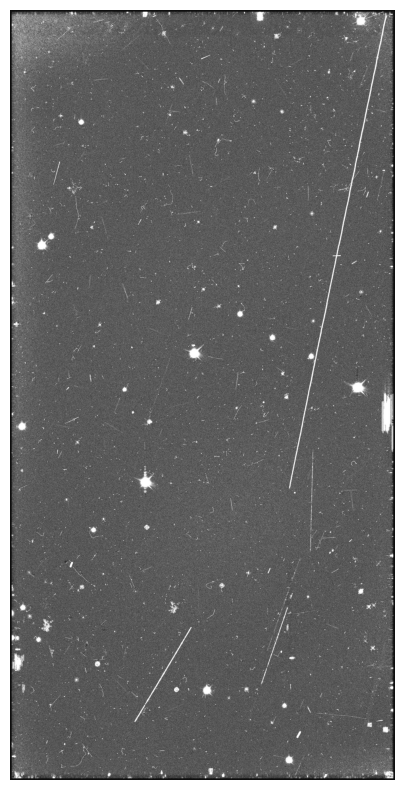

In [ ]:
COCO_CLASSES = {0: "Background", 1: "Moving object"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores

    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.8

    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    img_pil = Image.open(image_path).convert("RGB")
    plt.imshow(img_pil)

    w_size, h_size = img_pil.size
    img_size =512

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            # x_min *= img_size
            # y_min *= img_size
            # x_max *= img_size
            # y_max *= img_size

            class_name = get_class_name(label)  # Get the class name
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              linewidth=2, edgecolor='g', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='g')

    plt.axis('off')  # Turn off axis
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size

Use below code to visulize the bounding boxes

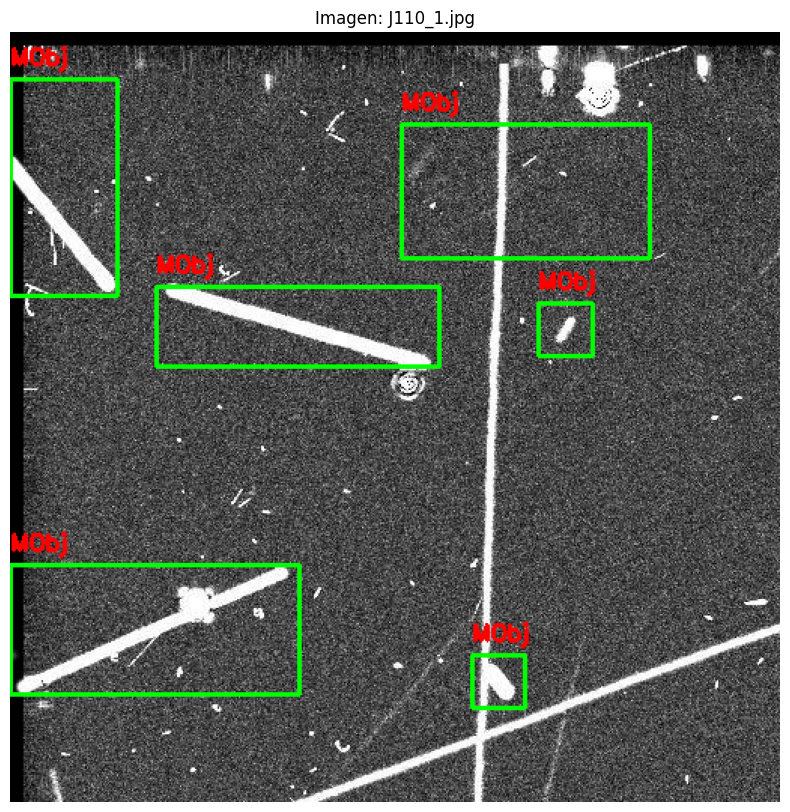

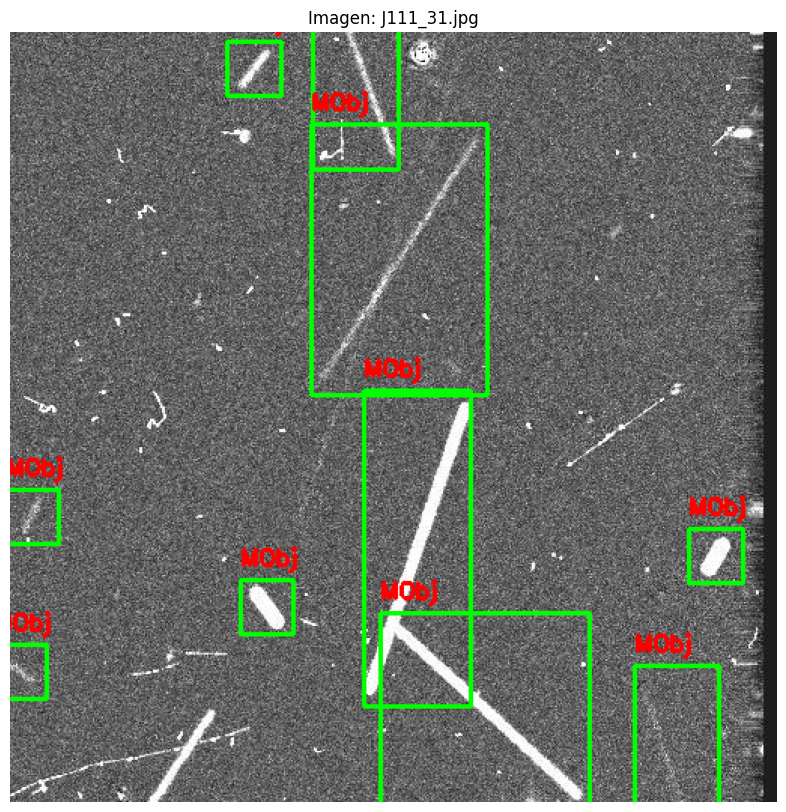

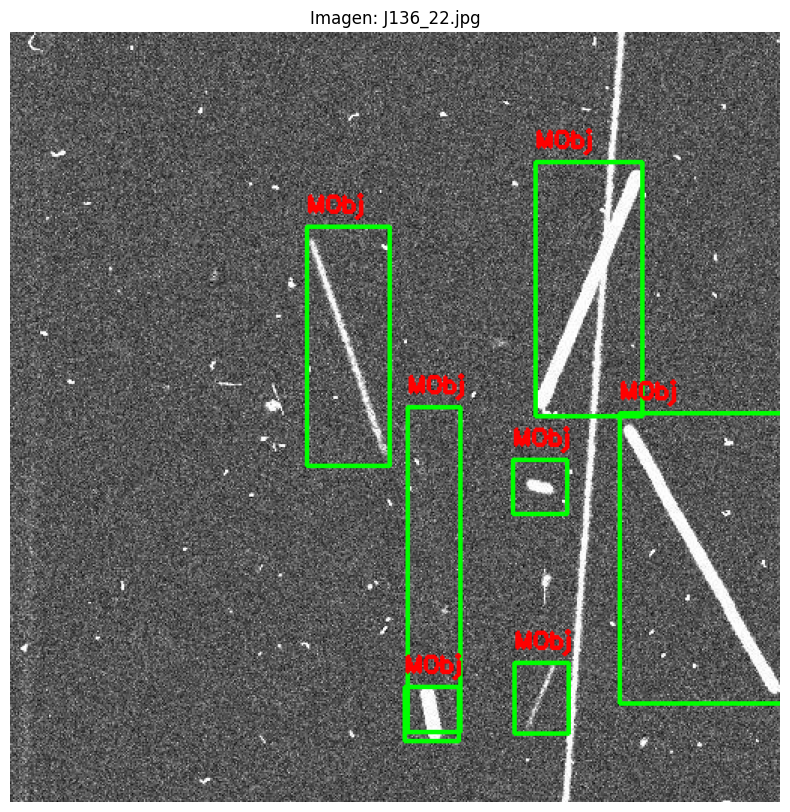

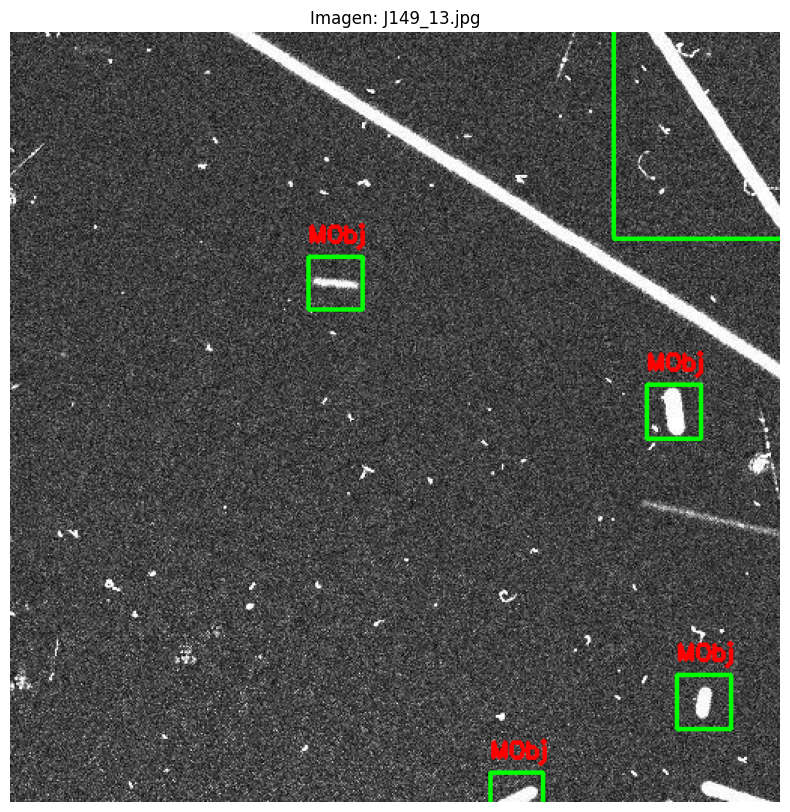

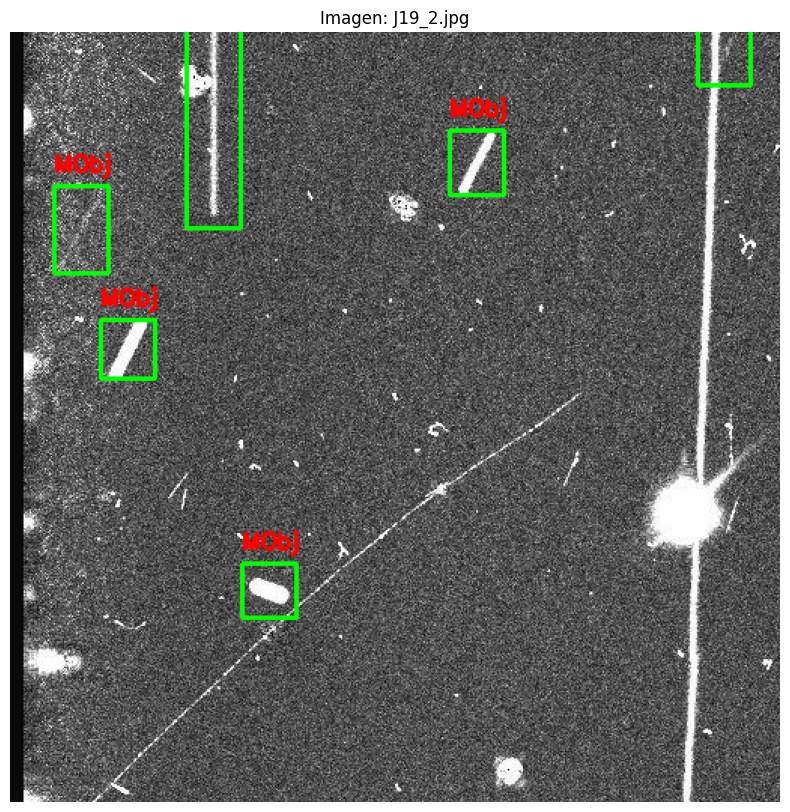

In [ ]:
'''In this part I will draw some Bounding boxes in the images. '''
import json
import cv2

test_images_for_bbox= ['J110_1.jpg', 'J111_31.jpg', 'J136_22.jpg', 'J149_13.jpg', 'J19_2.jpg']
t_img_dir = '/content/drive/MyDrive/Colab Notebooks/R-CNN/data/train/images/'
# Load the annotations from json file
with open(t_ann_file, "r") as f:
    data = json.load(f)

# Crear un diccionario para acceder a las imágenes por su id
images_dict = {img["id"]: img["file_name"] for img in data["images"]}

# Crear un diccionario para las categorías (id -> nombre)
categories_dict = {cat["id"]: cat["name"] for cat in data["categories"]}

# Agrupar las anotaciones por `image_id`
annotations_by_image = {}
for annotation in data["annotations"]:
    image_id = annotation["image_id"]
    if image_id not in annotations_by_image:
        annotations_by_image[image_id] = []
    annotations_by_image[image_id].append(annotation)

# Dibujar bounding boxes en las imágenes seleccionadas
for image_id, annotations in annotations_by_image.items():
    # Obtener el nombre de la imagen
    if image_id not in images_dict:
        continue
    image_name = images_dict[image_id]

    if image_name not in test_images_for_bbox:
        continue

    image_path = t_img_dir + image_name

    # Cargar la imagen
    image = cv2.imread(image_path)
    if image is None:
        print(f"No se pudo cargar la imagen: {image_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para mostrar con matplotlib# Obtener el nombre de la imagen

    # Obtener las dimensiones de la imagen
    img_pil = Image.open(image_path).convert("RGB")
    w_size, h_size = img_pil.size

    for annotation in annotations:
        bbox = annotation["bbox"]  # Coordenadas normalizadas [x_min, y_min, width, height]
        category_id = annotation["category_id"]
        x_center, y_center, w, h = bbox
        x_min = (x_center - w/2 ) * w_size
        y_min = (y_center - h/2) * h_size
        x_max = (x_center + w/2) * w_size
        y_max = (y_center + h/2) * h_size
        # Obtener el nombre de la categoría
        category_name = categories_dict[category_id]


        # Dibujar el bounding box y la etiqueta
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)  # Bounding box verde
        cv2.putText(image, category_name, (int(x_min), int(y_min - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Texto azul

    # Mostrar la imagen con todos los bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Imagen: {image_name}")
    plt.show()



# Model Improvements


## Training data optimization

* Data Labeled: check bounding boxes and classes are correct.

* Data augmentation: we add more data by applying transformations like rotations or magnitudes changes, then we get more data for training part.

* Normalization: the images have to be correctly normalized for the model. We are doing that, when we transform the image to a tensor, for the model. The bbox are also normalized in annotations files.


## Model settings

* Fine-tunning the Backbone (is used for obtain the feature map).
* Change the Backbone for more powerful one like: *ResNet101, Efficient Net* or *Swin Transformer.*

```
from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet101

backbone = resnet101(pretrained=True)
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])  # Elimina capas FC
backbone.out_channels = 2048  # ResNet101 output

model = FasterRCNN(backbone, num_classes=2)
```

## Training improvements techniques

* Focal loss: use a function loss that penalizes false negatives.


```
from torchvision.ops import sigmoid_focal_loss
loss = sigmoid_focal_loss(predictions, targets, alpha=0.25, gamma=2)
```



* Batch size and Learning rate : we can reduce the batch size for high resolution images. Also we can use learning rate schedule like CosineAnnealing or ReduceLROn Plateau.

## Post Processing

* use a Non Maximum Suppression (NPS) to eliminate the redundant bounding boxes.

